In [1]:
import sys

sys.path.append("../")


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from datetime import datetime, timedelta
from arch.unitroot import PhillipsPerron
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

DATA_PATH = 'D:\\Trading\\trading-agent\\crypto-pair-trading\\data'

In [6]:
import traceback

selected_pairs = ['BTC-USDT', 'ETH-USDT', 'BCH-USDT', 'LTC-USDT']

data = []
start_date = '2018-01-03'

for symbol in selected_pairs:
    try:
        df = pd.read_csv(f'{DATA_PATH}/{symbol}.csv', 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(df[df.index > start_date][symbol])
    except:
        traceback.print_exc()

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,BTC-USDT,ETH-USDT,BCH-USDT,LTC-USDT
open_time,,,,
2018-06-26,429.34,429.34,694.69,75.54
2018-06-27,441.64,441.64,713.05,80.60
2018-06-28,420.22,420.22,659.65,74.05
2018-06-29,434.77,434.77,716.40,78.94
2018-06-30,454.09,454.09,748.15,81.33


In [7]:
def adf_test(timeseries, verbose=False):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    if verbose:
        print ('Results of Dickey-Fuller Test:')
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    return dfoutput['p-value']

In [1]:
def pp_test(timeseries, verbose=False):
    pp = PhillipsPerron(timeseries)
    if verbose:
        print(pp.summary().as_text())
    
    return pp.pvalue


def kpss_test(timeseries, verbose=False):
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])

    if verbose:
        print ('Results of KPSS Test:')
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        print (kpss_output)
    return kpss_output['p-value']


In [9]:
methods = {
    'adf': adf_test,
    'pp': pp_test,
    'kpss': kpss_test
}


def perform_test(method, series):
    func_ = methods[method]
    
    # p_v1 = func_(np.log(series))
    p_v1 = func_(series)

    # diff = np.log(series) - np.log(series.shift(1))
    diff = series.diff()
    diff.dropna(inplace=True)
    p_v2 = func_(diff)

    return p_v1, p_v2

In [10]:
data = {
    'adf': [],
    'pp': [],
    'kpss': []
}
columns = []

for col in df.columns:
    for test in methods.keys():
        p1, p2 = perform_test(test, df[col])
        data[test].append(p1)
        data[test].append(p2)
    
    if col not in columns:
        columns.append(col)
    
    if f'd_{col}' not in columns:
        columns.append(f'd_{col}')

    

test_df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
test_df.head()

C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
C:\Users\Admin\anaconda3\envs\mlfin\lib\site-pack

,BTC-USDT,d_BTC-USDT,ETH-USDT,d_ETH-USDT,BCH-USDT,d_BCH-USDT,LTC-USDT,d_LTC-USDT
adf,0.575746,2.086989e-11,0.575746,2.086989e-11,0.149854,8.440609e-27,0.416222,4.295237e-26
pp,0.653267,1.798817e-24,0.653267,1.798817e-24,0.163568,8.987973e-27,0.477950,2.126329e-26
kpss,0.010000,1.000000e-01,0.010000,1.000000e-01,0.010000,1.000000e-01,0.010000,1.000000e-01


The prices are not stationary but they all become stationary after the first differencing.
For both adf and pp for the first differencing, `p-value` < 0.05 so we can reject the null.
KPSS all 3 diff series is above the critical value so we can accept the null (series is stationary).

Therefore, we can conclude that ETH, BCH, XLM are `I(1)` processes.

which:
- I(0): trend stationary
- I(1): diference stationary


The Engle-Granger method involves a linear regression on given time series data which,
in this case, is BTC; but it is not important which cryptocurrency is taken as the dependent
variable. We propose the following OLS model:

$$
ETH_t = c + \beta_1 BCH_t + \beta_2 XLM_t + \epsilon_t
$$

In [11]:
renamed = {col: col.replace('-USDT', '') for col in df.columns}

df.rename(columns=renamed, inplace=True)

In [12]:
df = sm.add_constant(df)
df

,const,BTC,ETH,BCH,LTC
open_time,,,,,
2018-01-04,1.0,940.00,940.00,2362.74,233.00
2018-01-05,1.0,959.30,959.30,2398.00,240.54
2018-01-06,1.0,1004.11,1004.11,2524.72,275.28
2018-01-07,1.0,1123.09,1123.09,2523.10,269.01
2018-01-08,1.0,1133.18,1133.18,2409.29,252.65
...,...,...,...,...,...
2018-06-26,1.0,429.34,429.34,694.69,75.54
2018-06-27,1.0,441.64,441.64,713.05,80.60
2018-06-28,1.0,420.22,420.22,659.65,74.05


In [13]:

model = sm.OLS.from_formula(formula='BTC ~ const + LTC + BCH + ETH', data=df)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.399e+31
Date:                Mon, 27 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:00:05   Log-Likelihood:                 4846.8
No. Observations:                 178   AIC:                            -9686.
Df Residuals:                     174   BIC:                            -9673.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.784e-14   5.13e-14     -1.127      0.2

From above Table, we obtain the relationships:

$$
ETH = 0.38 + 1.141BCH + 0.08XLM + \epsilon_t
$$

Notably, all the regressing coefficients appear to be statistically significant with p-values less than 1%.
R-squared: 0.935%.

In [14]:
results.resid.head()

open_time
2018-01-04   -9.094947e-13
2018-01-05   -9.094947e-13
2018-01-06   -1.136868e-12
2018-01-07   -9.094947e-13
2018-01-08   -6.821210e-13
dtype: float64

In [15]:
results.params

Intercept   -5.784262e-14
const       -2.886580e-14
LTC          3.830269e-15
BCH          4.718448e-16
ETH          1.000000e+00
dtype: float64

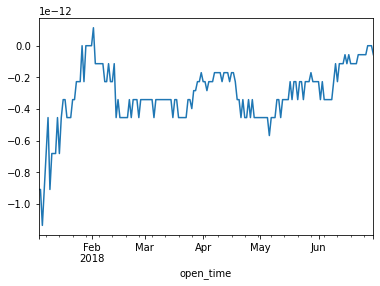

In [16]:
results.resid.plot()

In [17]:
adf_test(results.resid, verbose=True)

Results of Dickey-Fuller Test:
Test Statistic                  -3.009746
p-value                          0.033994
#Lags Used                       4.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64


0.033994257423823136

In [18]:
pp_test(results.resid, verbose=True)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -4.123
P-value                         0.001
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


0.0008875939506716571

In [19]:
kpss_test(results.resid, verbose=True)

Results of KPSS Test:
Test Statistic           0.445063
p-value                  0.057731
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


0.057731358980999015

In [24]:
s1 = df['BTC']
s2 = df['ETH']
s3 = df['BCH']
s4 = df['LTC']

hedge_ratio = (results.params['ETH'], results.params['BCH'], results.params['LTC'])
print(hedge_ratio)

spread = s1 - hedge_ratio[0] * s2 - hedge_ratio[1] * s3 - hedge_ratio[2] * s4
spread 

(0.9999999999999989, 4.718447854656915e-16, 3.83026943495679e-15)


open_time
2018-01-04   -9.841178e-13
2018-01-05   -1.029635e-12
2018-01-06   -1.108804e-12
2018-01-07   -1.084024e-12
2018-01-08   -7.402864e-13
                  ...     
2018-06-26   -1.623771e-13
2018-06-27   -1.335779e-13
2018-06-28   -1.401365e-13
2018-06-29   -1.856437e-13
2018-06-30   -1.529357e-13
Freq: D, Length: 178, dtype: float64

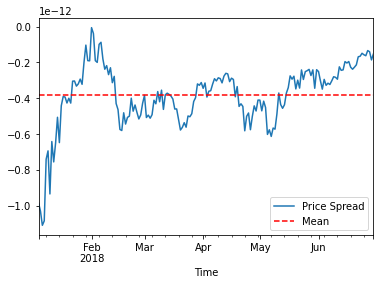

In [21]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

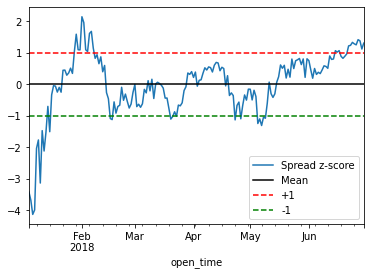

In [23]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])